In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import gudhi as gd  

In [2]:
networks={}
for name in ['PCD','CHR','DNA']:
    cName = 'Consensus '+name
    networks[cName]=nx.read_edgelist('1 output\\'+cName)
    networks[cName].name=cName
    
[nx.info(G) for G in networks.values()]

["Graph named 'Consensus PCD' with 170 nodes and 1840 edges",
 "Graph named 'Consensus CHR' with 162 nodes and 1297 edges",
 "Graph named 'Consensus DNA' with 233 nodes and 4616 edges"]

In [8]:
def removeNodesReturnLCC(G,removeSet):
    newG=G.copy()
    newG.remove_nodes_from(G.nodes&removeSet)
    newG=nx.subgraph(newG,max(nx.connected_components(newG),key=len))
    return newG

In [9]:
def persistantHomologyFromNetworkWithRips(G,name,dim,plot=True):      
    dm=pd.DataFrame(dict(nx.shortest_path_length(G))).sort_index()
    dm=dm[sorted(dm.columns)]
    skeleton = gd.RipsComplex(distance_matrix = dm.values) 

    Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension = dim)
    
    BarCode = Rips_simplex_tree.persistence()
      
    #----Simplexes Resume
    simplexesLen={}
    for simplex,filtration in Rips_simplex_tree.get_filtration():
        if(len(simplex)-1 not in simplexesLen):
            simplexesLen[len(simplex)-1]=1
        else:
            simplexesLen[len(simplex)-1]+=1    

    simplexesResume=''
    for item in simplexesLen.items():
        simplexesResume+=str(item[0])+': '+str(item[1])+' | '
    simplexesResume[0:-3]  
    
    #----Barcode Resume
    
    dimensionsLen={}
    for dim in range(0,dim+1):
        dimensionsLen[dim]=len([bd for bd in BarCode if (bd[0]==dim)])

    dimensionResume=''
    for item in dimensionsLen.items():
        dimensionResume+=str(item[0])+': '+str(item[1])+' | '
    dimensionResume[0:-3]    
            
    #--Plot
    if plot:
        plt.figure(figsize=(10,10),dpi=250)
        gd.plot_persistence_barcode(BarCode,axes=plt.gca());    
        plt.title(name+'\n Simplexes: '+simplexesResume[0:-3]+'\n Numbers of Bars: '+dimensionResume[0:-3],fontsize=9)
        plt.tight_layout()
        plt.savefig('./3 output/Barcode - '+name+' - Rips.png',dpi=500,facecolor='white')
        plt.show()
    
    with open('3 output/'+name+'.pkl',mode='wb') as f:
        pickle.dump(BarCode,f)

## Removendo Drivers

In [3]:
#http://ncg.kcl.ac.uk/statistics.php
knowDriversSetNcg=set(pd.read_csv('./3 input/ncg_canonical.txt',sep='\t',header=None)[0])
#https://www.intogen.org/search
knowDriversDF = pd.read_csv('./3 input/intogen.tsv',sep='\t')
knowDriversSetIntogen=set(knowDriversDF['SYMBOL'])

knowDriversUnion = knowDriversSetNcg.union(knowDriversSetIntogen)

In [4]:
# qtd de drivers em cada rede
for name,G_original in networks.items():
    totalDrivers=len(G_original.nodes&knowDriversUnion)
    percentual=round(totalDrivers/len(G_original.nodes)*100)
    print(name +' - '+ str(totalDrivers) +' ('+  str(percentual)+'%)')

Consensus PCD - 25 (15%)
Consensus CHR - 43 (27%)
Consensus DNA - 44 (19%)


usetex mode requires TeX.


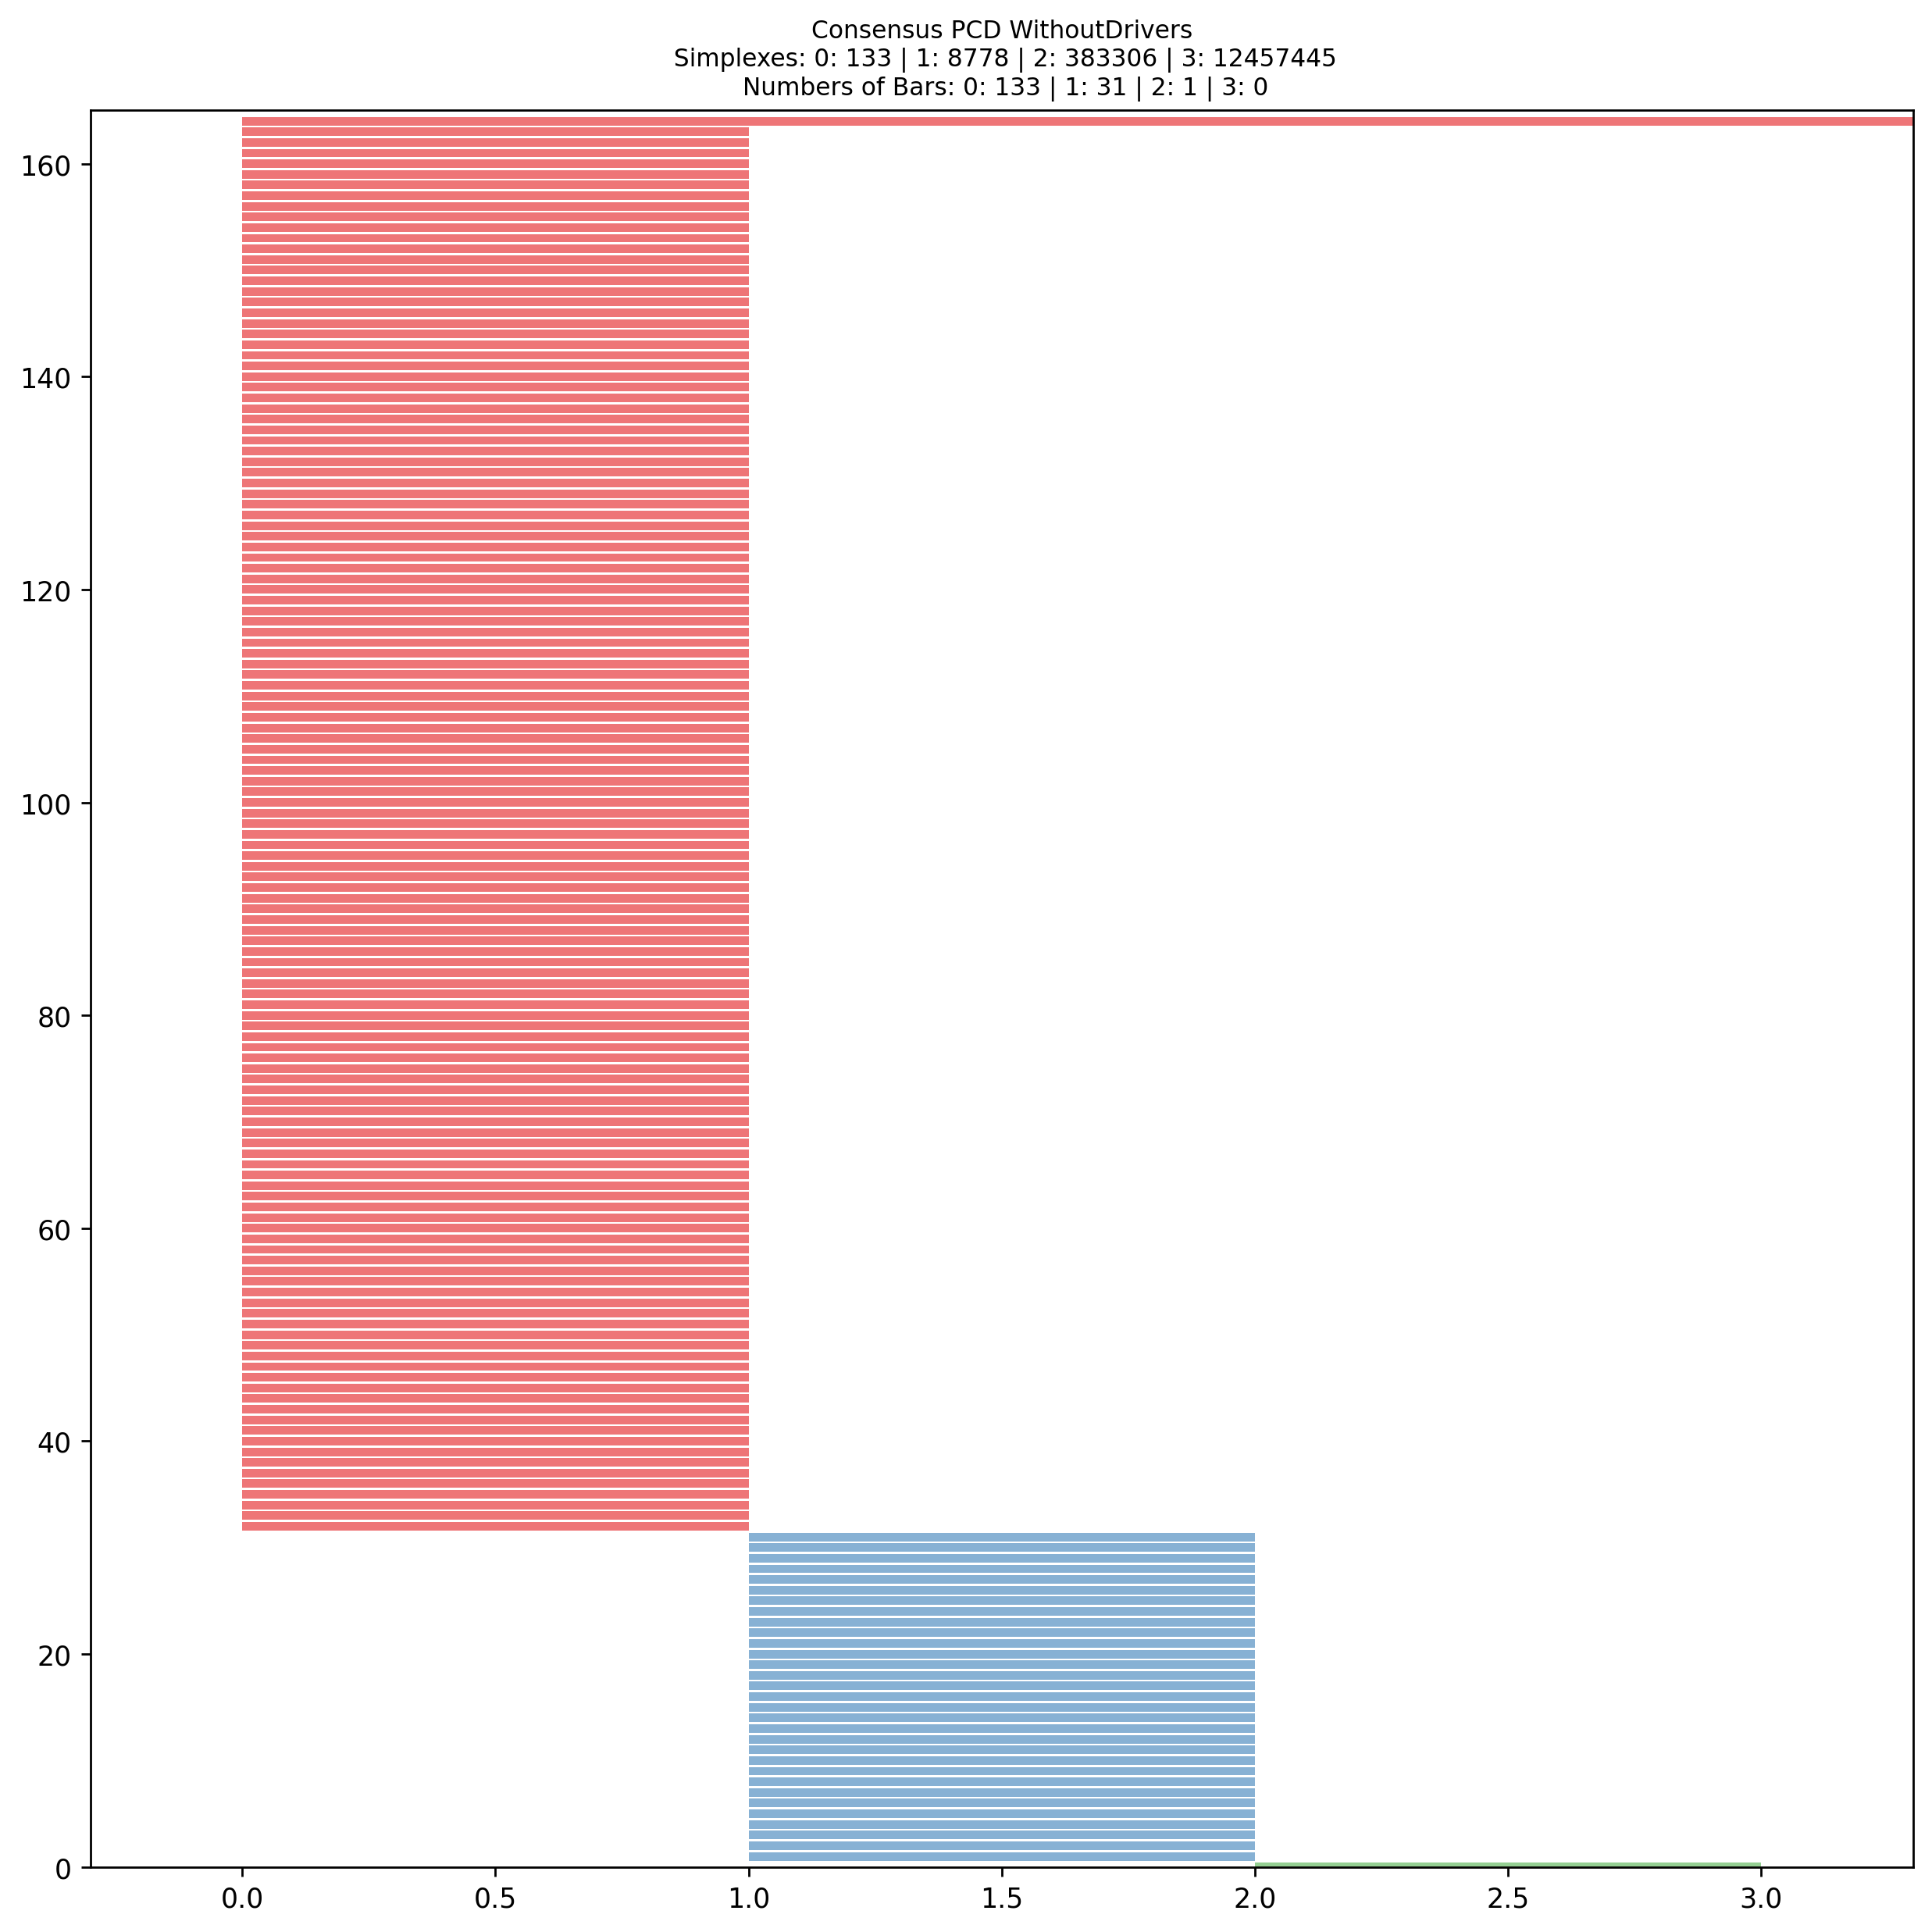

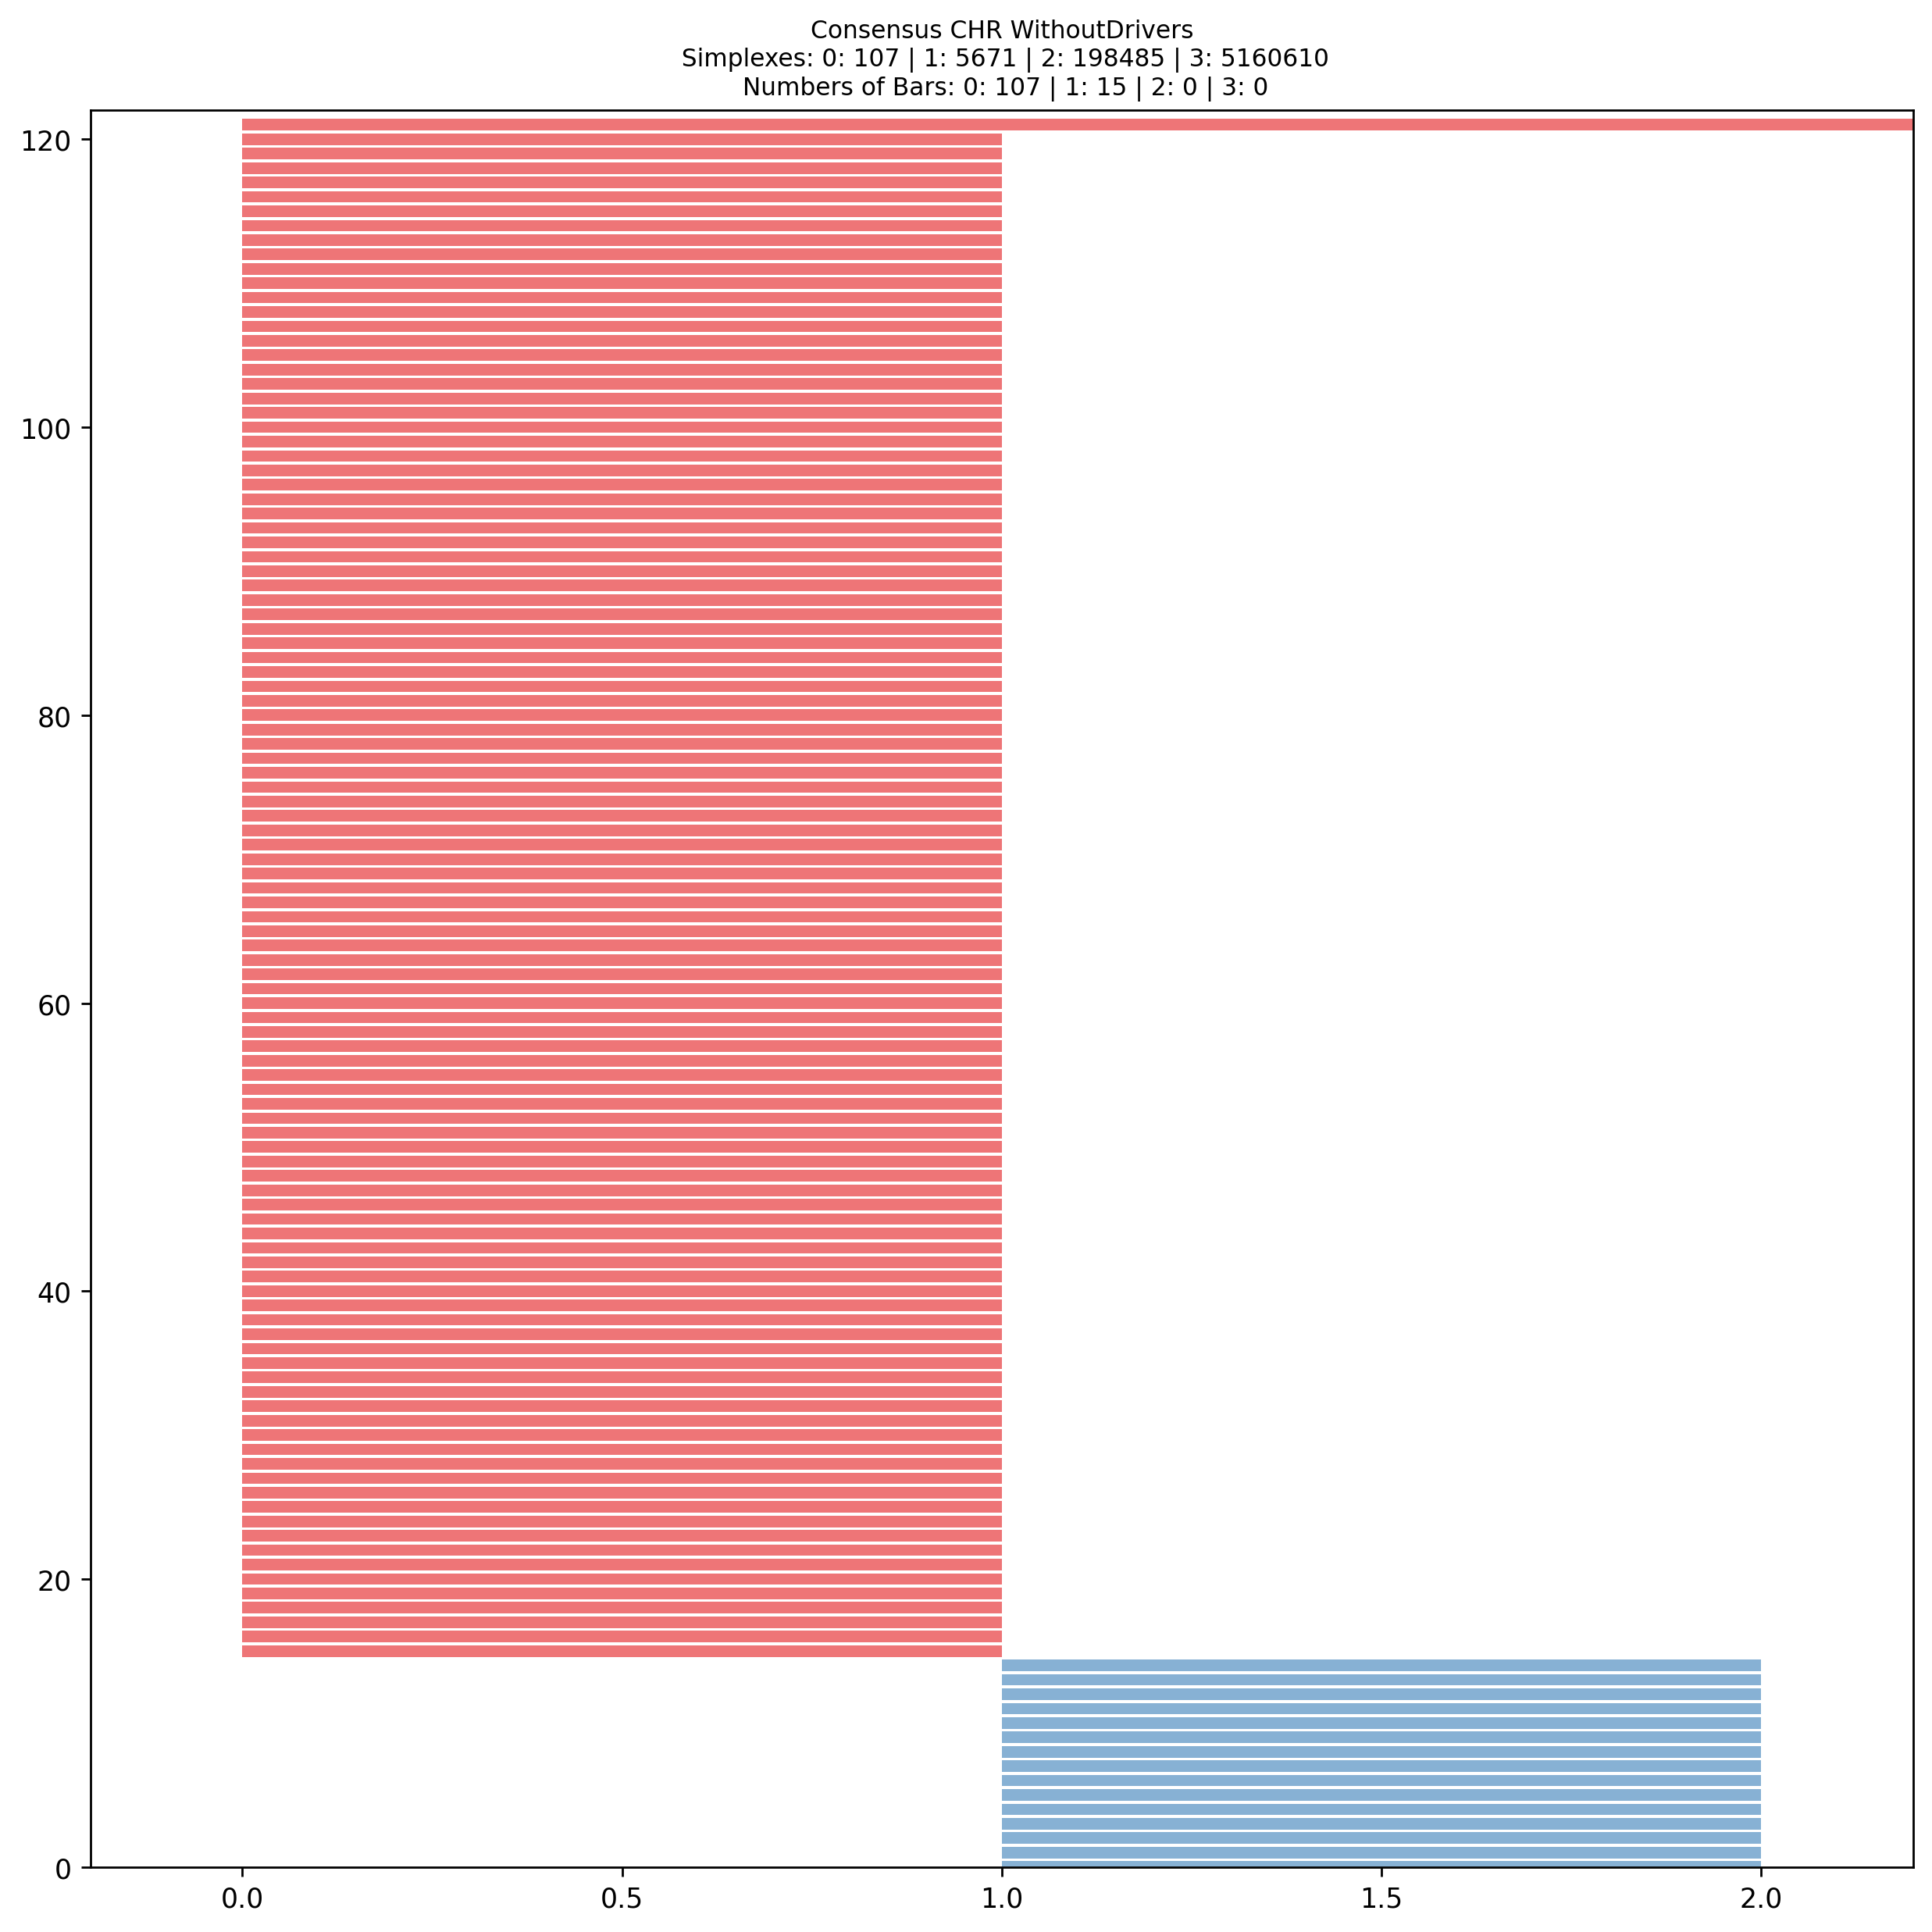

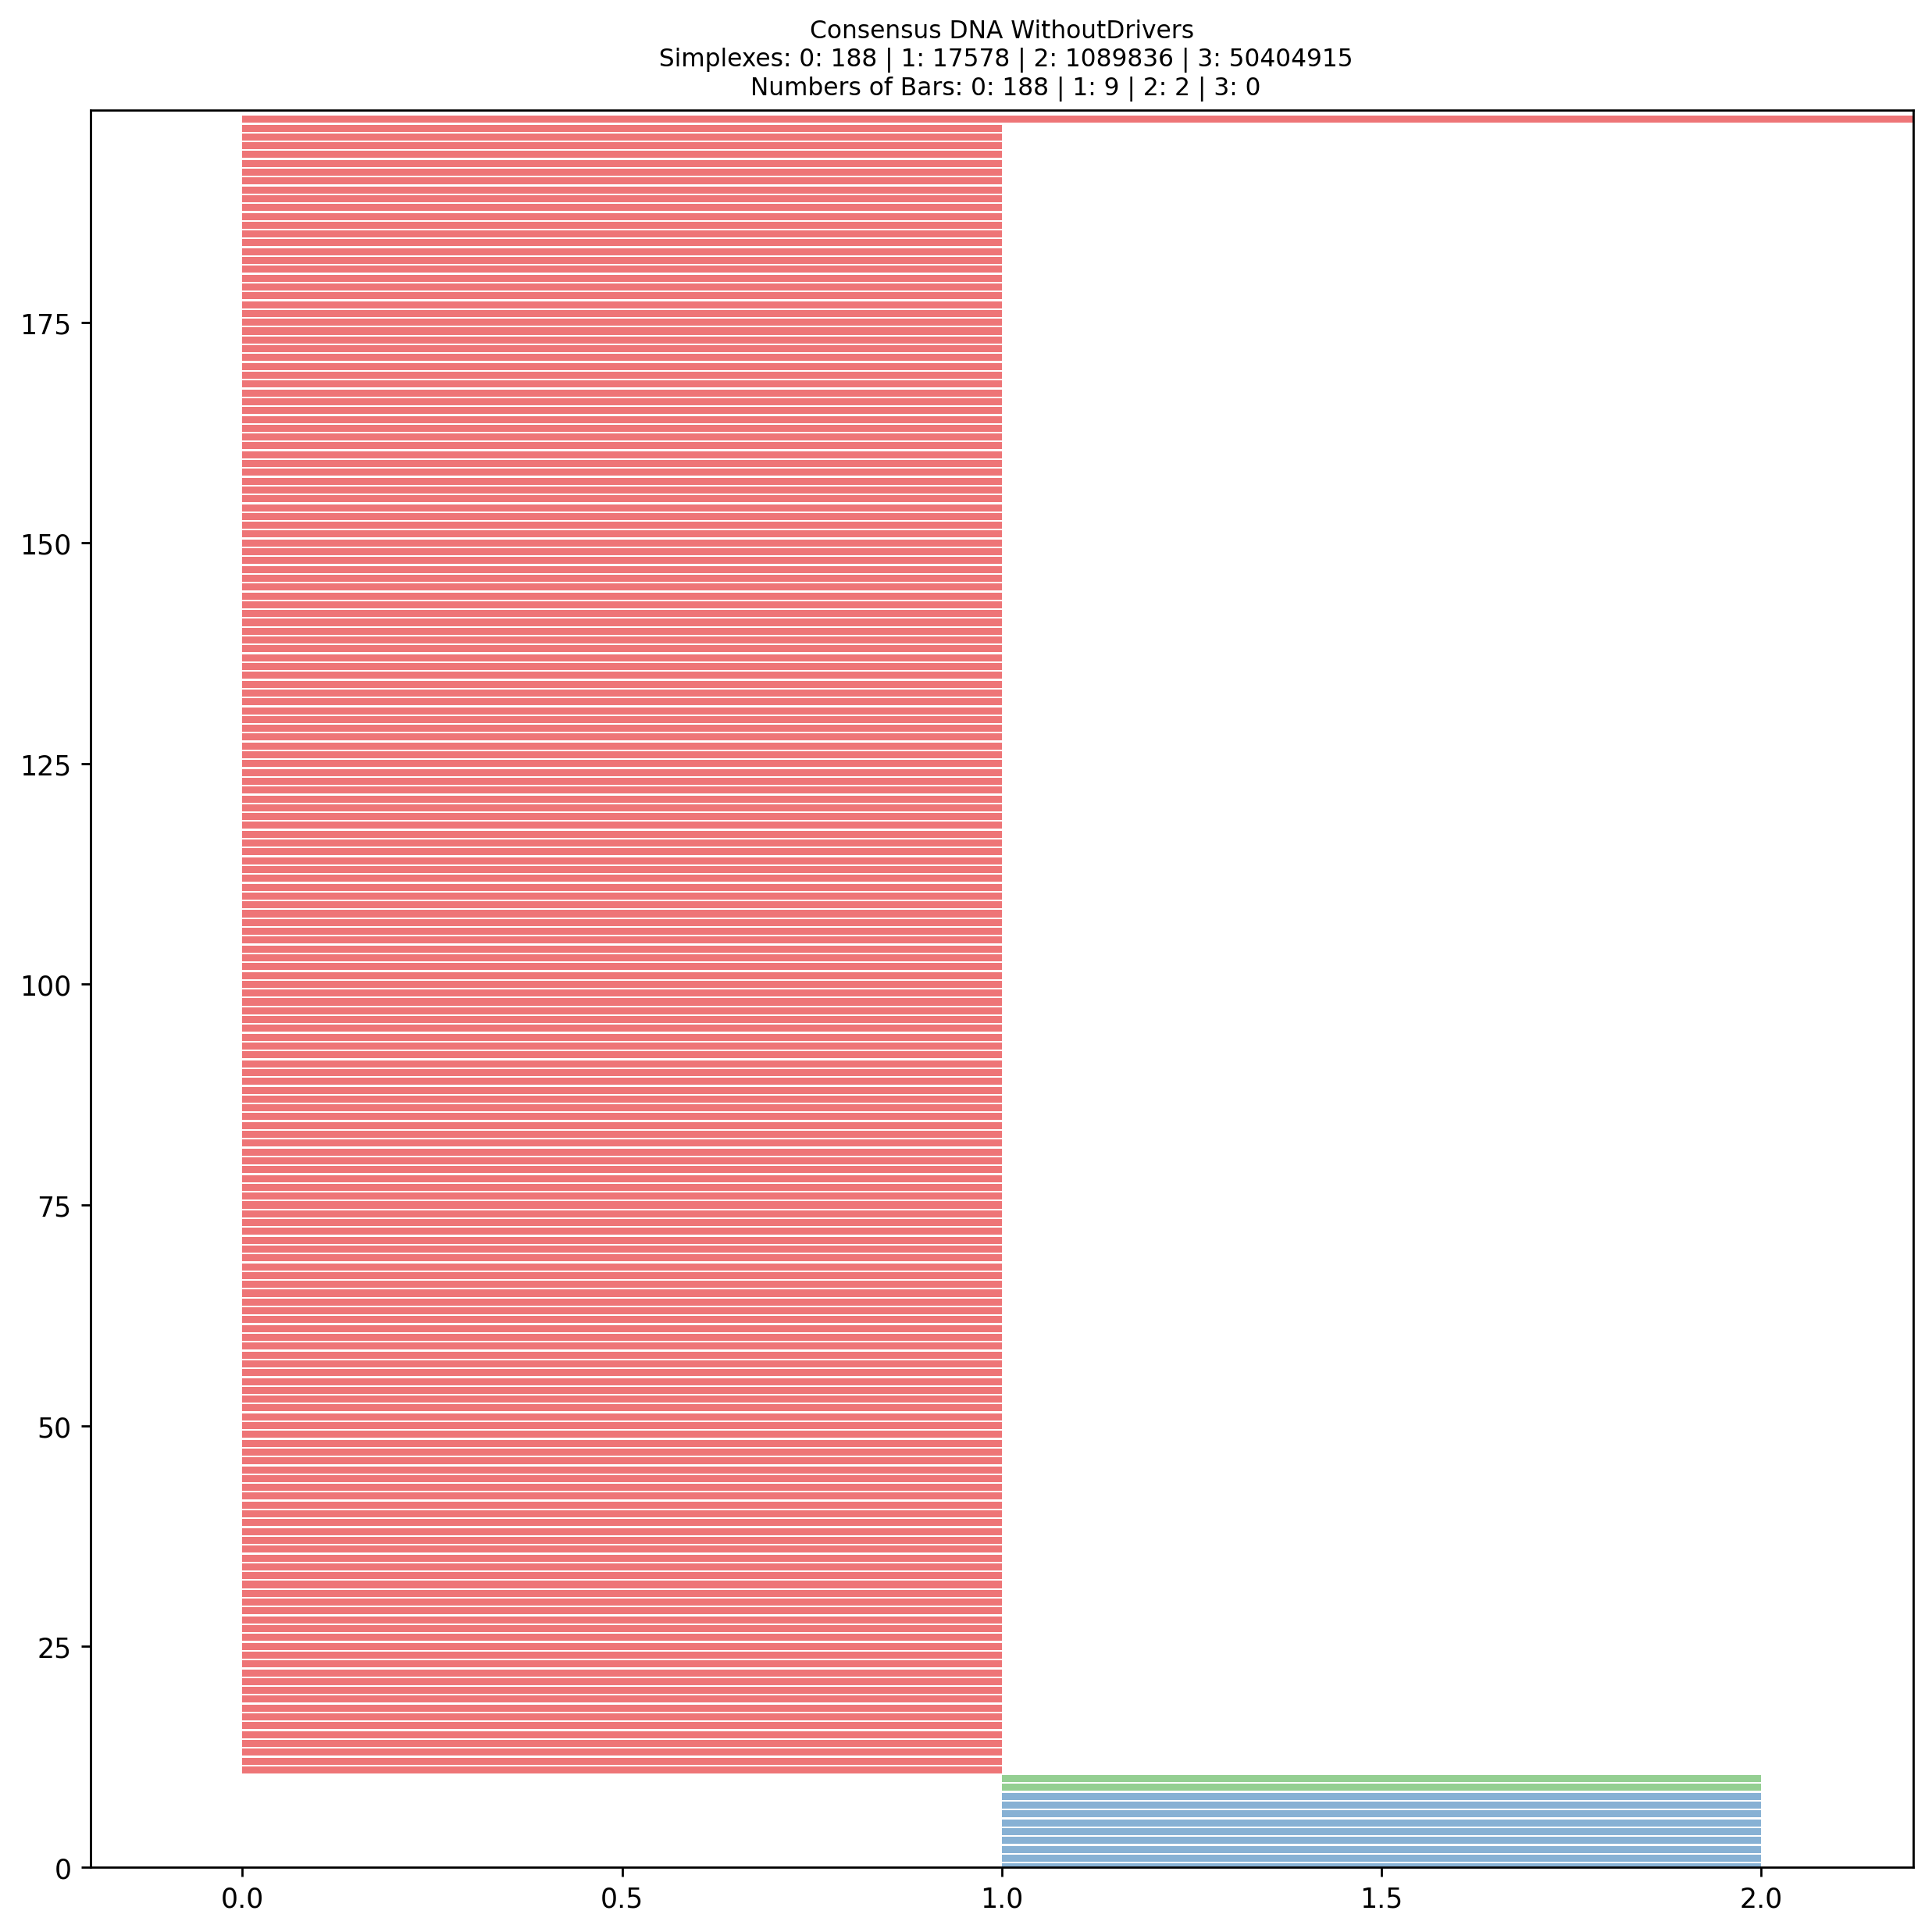

In [10]:
for name,G_original in networks.items():
    G=removeNodesReturnLCC(G_original,knowDriversUnion)
    persistantHomologyFromNetworkWithRips(G,name+' WithoutDrivers',3)
    

## Removendo Random

In [11]:
import random
randomRemovals=30

In [14]:
for name,G_original in networks.items():
    nodesToRemoveLen=len(G_original.nodes&knowDriversUnion)
    nodeList=list(G_original.nodes)

    #REMOÇÃO SEM DRIVERS
    nodeList=list(set(nodeList)-knowDriversUnion)

    for i in range(1,randomRemovals+1):
        random.shuffle(nodeList)
        G=removeNodesReturnLCC(G_original,nodeList[:nodesToRemoveLen])    
        persistantHomologyFromNetworkWithRips(G,name+' WithoutRandom '+str(i),3,plot=False)